In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from konlpy.tag import Mecab
mecab = Mecab()

#import lightgbm as lgb

ModuleNotFoundError: No module named 'konlpy'

In [2]:
import tensorflow as tf
import keras

/Users/a80099707/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/a80099707/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/a80099707/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a80099707/anaconda3/lib/python3.6/site-packages/tensorflow/pyth

In [3]:
df = pd.read_csv('./train.csv')

In [4]:
def parse_sentence(sentence):
    ret = []
    nouns = []
    condition = False
    for word in mecab.pos(sentence):
        # 계시다면 등에서 다면이 N으로 파싱됨
        if word[1][:1] == 'N':
            if word[0][:2] in ('경우', '필요', '라면', '다면'): # 경우, 필요 단어 등장 시 조건절로 판단
                condition = True
            else:
                nouns.append(word[0])
        # 도 : 여도, 라도
        # 면 : 라면, 면
        elif word[1] == 'EC' and (word[0][-1:] in ('면', '도') or word[0][-2:] in ('도록')):
            condition = True
        elif word[1][-2:] in ('EF'): # and word[0][-1:] in ['요', '다']:
            ret.append((word[0], condition, nouns))
            nouns = []
            condition = False
    if len(nouns) > 0:
        ret.append((word[0], condition, nouns))
    return ret

In [5]:
smishings = []
normals = []
idx = 0
for idx, item in df.iterrows():
    #print(item.text)
    splited = parse_sentence(item.text)
    splited.append(item.id)
    #splited = m.parse(item.text).split()
    if item.smishing == 1:
        smishings.append(splited)
    else:
        normals.append(splited)
    if idx % 100000 == 0:
        print(datetime.now(), idx)
    idx += 1
#     if idx > 20000:
#         break

2019-12-19 09:10:08.445862 0
2019-12-19 09:10:42.596852 100000
2019-12-19 09:11:22.005942 200000


In [6]:
class wordCounter():
    def __init__(self):
        self.word_bank = {}
    
    def add_bucket(self, bucket_name):
        self.word_bank[bucket_name] = {}
        
    def add_list(self, bucket_name, word_list:[]):
        bucket = self.word_bank[bucket_name]
        for keyword in word_list:
            if keyword in bucket:
                bucket[keyword] += 1
            else:
                bucket[keyword] = 1
                
    def get_counts(self, bucket_name):
        return self.word_bank[bucket_name]

In [7]:
wc = wordCounter()
wc.add_bucket('conditioned')
wc.add_bucket('general')

for normal in normals:
    for item in normal[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

for smishing in smishings:
    for item in smishing[:-1]:
        if item[1] == True:
            wc.add_list('conditioned', item[2])
        else:
            wc.add_list('general', item[2])

In [8]:
cond_test = pd.Series(wc.get_counts('conditioned'))
cond_test[cond_test.index.map(len) > 1].head(5)

첫날        37
누군가      243
행복      7014
문자     24826
라운지      531
dtype: int64

In [9]:
conditioned_df = pd.Series(wc.get_counts('conditioned'))
general_df = pd.Series(wc.get_counts('general'))

# 글자가 2개 이상인 것만 모아보자
conditioned_df = conditioned_df[conditioned_df.index.map(len) > 1]
general_df = general_df[general_df.index.map(len) > 1]

# 출현빈도가 일정 개수 이상되는 키워드만 표시해보면
display(conditioned_df[conditioned_df > 50])  # 조건절이 있는 문장에서 출현 빈도
display(general_df[general_df > 500])

누군가      243
행복      7014
문자     24826
라운지      531
이용     10696
       ...  
능연       112
대성       125
신전        53
자채        92
채팅       503
Length: 1576, dtype: int64

행성        683
팀장      31276
행복     102446
주말      49901
오늘      30655
        ...  
이용자       583
도최       1497
사대        968
모아        586
승인서       660
Length: 1089, dtype: int64

In [28]:
# size of feature vector : 아래 두 숫자를 합한 것만큼이 피쳐개수가 됨 \ 위의 출현개수 기반으로 판단해볼것
# 참고 : 400/400 에서 늘려서.. 700/500 800/400 600/600 이렇게 해봐도.. 아래 케이스에서 못맞히는 개수가 12~14개 꾸준함... ㅎㅎ
# 400/400 일 때는 15개 틀림.. 좀 늘리면 12개 까지는 좋아질 수 있음.. 합이 1200을 넘으면 너무 느려져서 사용불가 (이 mac기준)
CONDITION_WORD_FTR_SIZE = 400  
GENERAL_WORD_FTR_SIZE = 400

conditioned_dic = list(conditioned_df.sort_values(ascending=False).head(CONDITION_WORD_FTR_SIZE).index)
general_dic = list(general_df.sort_values(ascending=False).head(GENERAL_WORD_FTR_SIZE).index)

In [29]:
train_normal = []
train_smishing = []
train_conditioned = []
train_general = []

In [30]:
original_idx = []
for normal in normals:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in normal[:-1]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_normal.append((list(set(conditioned)), list(set(general))))
    train_conditioned.append(list(set(conditioned)))
    train_general.append(list(set(general)))
    original_idx.append(normal[-1])

In [31]:
for smishing in smishings:
    # 하나의 문자메시지에서 여러개의 문장이 있을 때, 한문장씩 처리(조건절 있는 경우 없는경우 나눠서)
    conditioned = []
    general = []
    for item in smishing[:-1]:
        if item[1] == True:  # conditioned
            conditioned += [x for x in item[2] if x in conditioned_dic]
        else:
            general += [x for x in item[2] if x in general_dic]
    train_smishing.append((list(set(conditioned)), list(set(general))))
    train_conditioned.append(list(set(conditioned)))
    train_general.append(list(set(general)))
    original_idx.append(smishing[-1])

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_conditioned = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
vectorizer_general = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)

tidf_conditioned = vectorizer_conditioned.fit_transform(train_conditioned)
tidf_general = vectorizer_general.fit_transform(train_general)

In [33]:
tidf_conditioned = np.array(tidf_conditioned.toarray())
tidf_general = np.array(tidf_general.toarray())
tidf_label = np.array([1 if x >= len(normals) else 0 for x in range(tidf_conditioned.shape[0])])

In [34]:
np.random.seed(0)
split = np.random.rand(tidf_conditioned.shape[0])
tidf_cond_train = tidf_conditioned[split < 0.6]
tidf_cond_valid = tidf_conditioned[(split >= 0.6) & (split < 0.8)]
tidf_cond_test = tidf_conditioned[split >= 0.8]

In [35]:
tidf_gen_train = tidf_general[split < 0.6]
tidf_gen_valid = tidf_general[(split >= 0.6) & (split < 0.8)]
tidf_gen_test = tidf_general[split >= 0.8]

In [36]:
tidf_label_train = tidf_label[split < 0.6]
tidf_label_valid = tidf_label[(split >= 0.6) & (split < 0.8)]
tidf_label_test = tidf_label[split >= 0.8]

In [37]:
tidf_cond_train.shape, tidf_cond_valid.shape, tidf_cond_test.shape

((177533, 400), (59281, 400), (59131, 400))

In [38]:
tidf_gen_train.shape, tidf_gen_valid.shape, tidf_gen_test.shape

((177533, 400), (59281, 400), (59131, 400))

In [39]:
n_cond, n_gen = CONDITION_WORD_FTR_SIZE, GENERAL_WORD_FTR_SIZE
num_predictive_factors = 64
cond_input = keras.layers.Input(shape=(n_cond,), name='Cond')
gen_input = keras.layers.Input(shape=(n_gen,), name='General')

#cond_vec_mlp = keras.layers.Embedding(n_cond, num_predictive_factors, )(cond_input)
#cond_vec_mlp = keras.layers.Flatten(name='Flattenconds-MLP')(cond_vec_mlp)
#cond_vec_mlp = keras.layers.Dropout(0.3)(cond_vec_mlp)

#gen_vec_mlp = keras.layers.Embedding(n_gen, num_predictive_factors)(gen_input)
#gen_vec_mlp = keras.layers.Flatten(name='Flattengens-MLP')(gen_vec_mlp)
#gen_vec_mlp = keras.layers.Dropout(0.3)(gen_vec_mlp)

concat_mlp = keras.layers.merge.concatenate([cond_input, gen_input])
concat_dropout_mlp = keras.layers.Dropout(0.3)(concat_mlp)

dense = keras.layers.Dense(256, name='FullyConnected-1')(concat_dropout_mlp)
dropout_1 = keras.layers.Dropout(0.2, name='Dropout-1')(dense)

dense_2 = keras.layers.Dense(128, name='FullyConnected-2')(dropout_1)
dropout_2 = keras.layers.Dropout(0.2, name='Dropout-2')(dense_2)

dense_3 = keras.layers.Dense(64, name='FullyConnected-3')(dropout_2)
dropout_3 = keras.layers.Dropout(0.2, name='Dropout-3')(dense_3)

dense_4 = keras.layers.Dense(32, name='FullyConnected-4', activation='relu')(dropout_3)

pred_mlp = keras.layers.Dense(1, activation='relu', name='Activation')(dense_4)

model = keras.Model(inputs=[cond_input, gen_input], output=pred_mlp)
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss='mae', metrics=['mae', 'accuracy'])

/Users/a80099707/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("Ac...)`


In [27]:
len(tidf_label_train), sum(tidf_label_train)

(177533, 11319)

In [40]:
# Train Model
history = model.fit(x=[tidf_cond_train, tidf_gen_train], y=tidf_label_train,
                batch_size=320,
                epochs=7,
                validation_data=([tidf_cond_valid, tidf_gen_valid], tidf_label_valid),
                verbose=1) #,callbacks=[csv_logger])

Train on 177533 samples, validate on 59281 samples
Epoch 1/7
177533/177533 [==============================] - 18s 102us/step - loss: 0.0111 - mean_absolute_error: 0.0111 - acc: 0.9976 - val_loss: 0.0091 - val_mean_absolute_error: 0.0091 - val_acc: 0.9996
Epoch 2/7
177533/177533 [==============================] - 16s 90us/step - loss: 0.0055 - mean_absolute_error: 0.0055 - acc: 0.9994 - val_loss: 0.0033 - val_mean_absolute_error: 0.0033 - val_acc: 0.9996
Epoch 3/7
177533/177533 [==============================] - 16s 90us/step - loss: 0.0030 - mean_absolute_error: 0.0030 - acc: 0.9994 - val_loss: 0.0023 - val_mean_absolute_error: 0.0023 - val_acc: 0.9996
Epoch 4/7
177533/177533 [==============================] - 16s 90us/step - loss: 0.0014 - mean_absolute_error: 0.0014 - acc: 0.9995 - val_loss: 8.9369e-04 - val_mean_absolute_error: 8.9369e-04 - val_acc: 0.9995
Epoch 5/7
177533/177533 [==============================] - 16s 91us/step - loss: 8.3132e-04 - mean_absolute_error: 8.3132e-04 - 

In [41]:
pred_test = model.predict(x=[tidf_cond_test, tidf_gen_test], batch_size=320)

In [44]:
gap = tidf_label_test - pred_test

KeyboardInterrupt: 

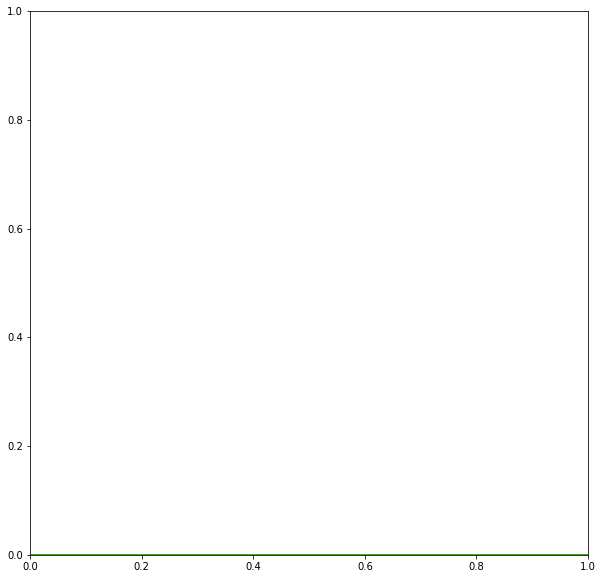

In [45]:
plt.figure(figsize=(10,10))
plt.plot(gap)

In [97]:
def view_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15,10))
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(history.history['loss'], 'y', label='train_loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

    acc_ax.plot(history.history['acc'], 'b', label='train_acc')
    acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuracy')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [98]:
# Train Model

tidf_cond_train_normal = tidf_cond_train[tidf_label_train == 0]
tidf_gen_train_normal = tidf_gen_train[tidf_label_train == 0]
tidf_cond_train_smishing = tidf_cond_train[tidf_label_train == 1]
tidf_gen_train_smishing = tidf_gen_train[tidf_label_train == 1]
sample_ratio = len(tidf_cond_train_smishing) / len(tidf_cond_train_normal)
print('sample_ratio:', sample_ratio)

sampling = np.random.rand(len(tidf_cond_train_normal)) < sample_ratio
cond_sample = tidf_cond_train_normal[sampling]
gen_sample = tidf_gen_train_normal[sampling]
sample_cond_train = np.concatenate([cond_sample, tidf_cond_train_smishing])
sample_gen_train = np.concatenate([gen_sample, tidf_gen_train_smishing])
sample_label_train = [1 if x >= len(cond_sample) else 0 for x in range(len(sample_cond_train))]
history = model.fit(x=[sample_cond_train, sample_gen_train], y=sample_label_train,
                batch_size=320,
                epochs=10,
                validation_data=([tidf_cond_valid, tidf_gen_valid], tidf_label_valid),
                verbose=1) #,callbacks=[csv_logger])

sample_ratio: 0.06789377124124034
Train on 22587 samples, validate on 59219 samples
Epoch 1/10
22587/22587 [==============================] - 49s 2ms/step - loss: 0.4999 - mean_absolute_error: 0.4999 - acc: 0.5002 - val_loss: 0.0637 - val_mean_absolute_error: 0.0637 - val_acc: 0.9363
Epoch 2/10
 3520/22587 [===>..........................] - ETA: 37s - loss: 0.5097 - mean_absolute_error: 0.5097 - acc: 0.4903

KeyboardInterrupt: 

<Figure size 1080x720 with 0 Axes>

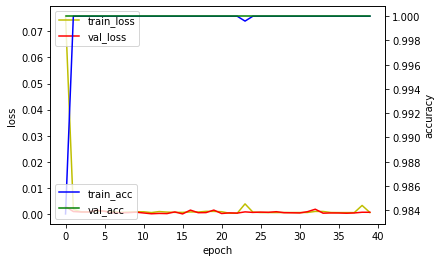

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(history.history['loss'], 'y', label='train_loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val_loss')

acc_ax.plot(history.history['acc'], 'b', label='train_acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

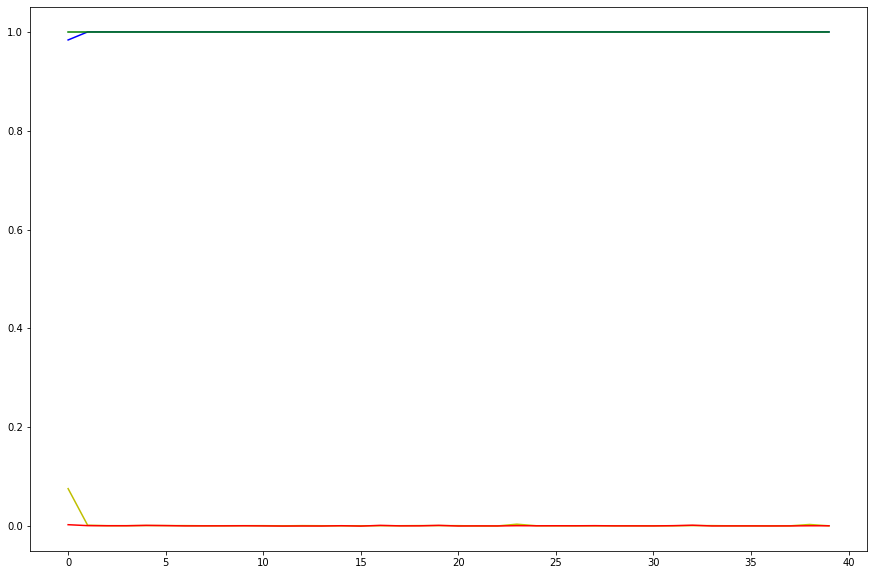

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
# fig, loss_ax = plt.subplots()
# acc_ax = plt.twinx()
plt.plot(history.history['loss'], 'y', label='train_loss')
plt.plot(history.history['val_loss'], 'r', label='val_loss')

plt.plot(history.history['acc'], 'b', label='train_acc')
plt.plot(history.history['val_acc'], 'g', label='val_acc')

plt.set_xlabel('epoch')
plt.set_ylabel('loss')
plt.set_ylabel('accuracy')
plt.legend(loc='upper left')
plt.legend(loc='lower left')

plt.show()

In [66]:
train_data = []
for idx in range(tidf_conditioned.shape[0]):
    row = []
    row += list(tidf_conditioned[idx].toarray()[0])  # ~면(조건절) 포함한 feature vector (tfidf)
    row += list(tidf_general[idx].toarray()[0])  # 조건절 외 feature vector (tfidf)
    row.append(1 if idx >= len(normals) else 0)  # smishing이면 1 아니면 0
    train_data.append(row)

In [67]:
train_data = pd.DataFrame(train_data)

In [68]:
train_data['id'] = pd.Series(original_idx)

In [69]:
np.random.seed(0)
split = np.random.rand(raw_size) < 0.2
test = train_data[split]
train_data2 = train_data[~split]
split = np.random.rand(raw_size - len(test)) < 0.8
train = train_data2[split]
valid = train_data2[~split]

In [70]:
train_X, train_y = train.iloc[:, :-2], train.iloc[:, -2]
valid_X, valid_y = valid.iloc[:, :-2], valid.iloc[:, -2]

In [71]:
lgb_train_data = lgb.Dataset(train_X, label=train_y)
lgb_valid_data = lgb.Dataset(valid_X, label=valid_y)

In [22]:
params = {'boosting_type': 'gbdt',
         'objective': 'binary',
         'learning_rate': 0.015, #0.035,
         'verbosity': 1
         }

In [23]:
bst = lgb.train(params, lgb_train_data,
               num_boost_round = 5000,
               early_stopping_rounds=10,
               valid_sets = [lgb_valid_data])

[1]	valid_0's binary_logloss: 0.223347
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.211335
[3]	valid_0's binary_logloss: 0.201287
[4]	valid_0's binary_logloss: 0.192587
[5]	valid_0's binary_logloss: 0.184912
[6]	valid_0's binary_logloss: 0.178038
[7]	valid_0's binary_logloss: 0.171797
[8]	valid_0's binary_logloss: 0.166099
[9]	valid_0's binary_logloss: 0.160833
[10]	valid_0's binary_logloss: 0.155952
[11]	valid_0's binary_logloss: 0.151384
[12]	valid_0's binary_logloss: 0.147102
[13]	valid_0's binary_logloss: 0.143067
[14]	valid_0's binary_logloss: 0.139254
[15]	valid_0's binary_logloss: 0.135643
[16]	valid_0's binary_logloss: 0.132212
[17]	valid_0's binary_logloss: 0.128942
[18]	valid_0's binary_logloss: 0.125822
[19]	valid_0's binary_logloss: 0.122846
[20]	valid_0's binary_logloss: 0.119996
[21]	valid_0's binary_logloss: 0.11726
[22]	valid_0's binary_logloss: 0.114613
[23]	valid_0's binary_logloss: 0.112068
[24]	valid_0's binary_logloss

[198]	valid_0's binary_logloss: 0.00746562
[199]	valid_0's binary_logloss: 0.00737102
[200]	valid_0's binary_logloss: 0.00727628
[201]	valid_0's binary_logloss: 0.00718343
[202]	valid_0's binary_logloss: 0.00709266
[203]	valid_0's binary_logloss: 0.00700093
[204]	valid_0's binary_logloss: 0.00691077
[205]	valid_0's binary_logloss: 0.00682305
[206]	valid_0's binary_logloss: 0.00673809
[207]	valid_0's binary_logloss: 0.00665206
[208]	valid_0's binary_logloss: 0.00657089
[209]	valid_0's binary_logloss: 0.00648916
[210]	valid_0's binary_logloss: 0.00640871
[211]	valid_0's binary_logloss: 0.00633096
[212]	valid_0's binary_logloss: 0.00625413
[213]	valid_0's binary_logloss: 0.00617681
[214]	valid_0's binary_logloss: 0.00610308
[215]	valid_0's binary_logloss: 0.00602865
[216]	valid_0's binary_logloss: 0.00595715
[217]	valid_0's binary_logloss: 0.00588532
[218]	valid_0's binary_logloss: 0.00581631
[219]	valid_0's binary_logloss: 0.00574596
[220]	valid_0's binary_logloss: 0.00567887
[221]	valid

[390]	valid_0's binary_logloss: 0.00133397
[391]	valid_0's binary_logloss: 0.00132861
[392]	valid_0's binary_logloss: 0.0013226
[393]	valid_0's binary_logloss: 0.00131757
[394]	valid_0's binary_logloss: 0.0013119
[395]	valid_0's binary_logloss: 0.00130607
[396]	valid_0's binary_logloss: 0.00130095
[397]	valid_0's binary_logloss: 0.00129482
[398]	valid_0's binary_logloss: 0.00128949
[399]	valid_0's binary_logloss: 0.00128356
[400]	valid_0's binary_logloss: 0.00127802
[401]	valid_0's binary_logloss: 0.00127203
[402]	valid_0's binary_logloss: 0.00126708
[403]	valid_0's binary_logloss: 0.00126198
[404]	valid_0's binary_logloss: 0.0012566
[405]	valid_0's binary_logloss: 0.00125085
[406]	valid_0's binary_logloss: 0.00124585
[407]	valid_0's binary_logloss: 0.0012412
[408]	valid_0's binary_logloss: 0.00123633
[409]	valid_0's binary_logloss: 0.00123092
[410]	valid_0's binary_logloss: 0.00122675
[411]	valid_0's binary_logloss: 0.00122229
[412]	valid_0's binary_logloss: 0.00121737
[413]	valid_0's

In [24]:
train.shape, valid.shape, test.shape

((189290, 802), (47266, 802), (59389, 802))

In [25]:
# test
test_X, test_y = test.iloc[:, :-2], test.iloc[:, -2]

In [26]:
predict_y = bst.predict(test_X)

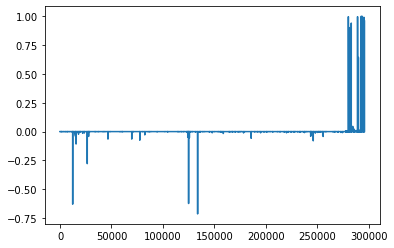

In [27]:
predict_y = pd.Series(predict_y)
predict_y.index = test_y.index
test_y = test_y
gap_y = test_y - predict_y
plt.plot(gap_y)

In [28]:
# 정답과 0.5 이상 차이나는 경우를 발라냄 (맨 마지막 id참조 차)
print(gap_y[np.abs(gap_y) > 0.5])
display(test.loc[gap_y[np.abs(gap_y) > 0.5].index, :])

12301    -0.629219
125003   -0.623554
133778   -0.713767
280342    0.996054
281226    0.901740
283169    0.940661
289270    0.994610
289284    0.996163
290109    0.642982
292846    0.999951
293697    0.999984
295167    0.984323
295243    0.660485
295426    0.991232
295921    0.964862
dtype: float64


,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,id
12301,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.278175,0.0,0.0,0.0,0,15346
125003,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.122440,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,148733
133778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.135807,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,159150
280342,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,136012
281226,0.0,0.151709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.294786,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,149117
283169,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,198614
289270,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,284019
289284,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,284067
290109,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,288183
292846,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,313012


In [29]:
wrong_cases = list(test.loc[gap_y[gap_y > 0.5].index].id)  # 스미싱인데 못맞춘 경우만 뽑기위해 abs빼고..

In [30]:
# id를 입력받으면 text와 parsed data출력
def check_meta(id, parsed=False):
    txt = df[df['id'] == id].iloc[0].text
    print(txt)
    if parsed: print(parse_sentence(txt))

In [1]:
(58000-15)/58000*100

99.97413793103448

In [31]:
[check_meta(x, True) for x in wrong_cases]

XXX개인신용XXX XXX입니다본격적인 휴가시즌이 되었네요.. 열심히 일한 우리모두 즐거운 휴가를 보내 보아요... 아직도 피싱사기는 줄어들지 않고 있습니다1. 금리인하 유혹-금전요구2. 금리조정 유도 대출금 재입금 요구3. 070 전화 유혹(XXX국민XXX저희은행사칭)4.지인 부채 보증진행인듯 실제 부채 발생5.카드깡유혹(실제 금융문란 제기될수있음)휴가철 들뜬 마음에 조금만 신경써도 당하지 않을 유혹 조심 하시구요늘 작은 의문이라도 있으면 언제든 상담 문의 해 드릴께요즐거운 점심시간 되시고 건강과 기쁨이 늘 곁에 있으면 좋겠습니다XXX XXX 드림XXX 개인신용XXX XXX입니
[('입니다', False, ['개인', '신용']), ('네요', False, ['본격', '휴가', '시즌']), ('아요', False, ['일', '우리', '휴가']), ('습니다', False, ['피싱', '사기']), ('구요', False, ['금리', '인하', '유혹', '금전', '요구', '금리', '조정', '유도', '대출금', '입금', '요구', '전화', '유혹', '국민', '저희', '은행', '사칭', '지인', '부채', '보증', '진행', '듯', '실제', '부채', '발생', '카드깡', '유혹', '실제', '금융', '문란', '제기', '수', '휴가철', '마음', '신경', '유혹', '조심']), ('드릴께요', True, ['의문', '언제', '상담', '문의']), ('습니다', True, ['점심', '시간', '건강', '기쁨', '곁']), ('니', False, ['개인', '신용'])]
SK브로드밴드-요금안내 XXX고객님 유선 서비스의 요금 납부 안내드립니다.  8월 8일일 기준 많이 바쁘셨는지 미납요금(25320원) 확인되어 연락드렸습니다.  납기일 경과로 오늘 납부 확인 되지 않으면 부XXX고객님께서 미납관련 연락을 받으시는 불편함이 우려되오니 확인 부탁드립니다. 전화상 편리한 신용카드 결제 실시간 계좌이체로 

[None, None, None, None, None, None, None, None, None, None]

In [33]:
mecab.pos('우대금리는 금리재산정 시점에서 각 항목의 충족할 수 있도록 제공되지 않을 수 있습니다')

[('우대금리', 'NNP'),
 ('는', 'JX'),
 ('금리', 'NNG'),
 ('재', 'XPN'),
 ('산정', 'NNG'),
 ('시점', 'NNG'),
 ('에서', 'JKB'),
 ('각', 'MM'),
 ('항목', 'NNG'),
 ('의', 'JKG'),
 ('충족', 'NNG'),
 ('할', 'XSV+ETM'),
 ('수', 'NNB'),
 ('있', 'VV'),
 ('도록', 'EC'),
 ('제공', 'NNG'),
 ('되', 'XSV'),
 ('지', 'EC'),
 ('않', 'VX'),
 ('을', 'ETM'),
 ('수', 'NNB'),
 ('있', 'VV'),
 ('습니다', 'EC')]

In [ ]:
# 아래와 같은 조건 절을 인식하지 못하는 문제가 있음 : 지금은 ~면 만 하고 있음
# 의 경우
# 경우에는
# 에 따라
# 필요시, 
# 원하시면. (띄워쓰지 않고 점이 있음..)

# 아래와 같은 피쳐를 고려할 것
# 문장의 개수 (긴 경우에 피싱이 많음.. )
# 숫자(X로 치환된 경우 포함)의 개수 (피싱의 경우 계좌번호 등을 보내서 송금유도 하는 경우 있음)


In [158]:
test = pd.read_csv('./public_test.csv')

In [159]:
test.head()

,id,year_month,text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...


In [177]:
idx = 0
nouns = []
for idx, item in test.iterrows():
    noun = [x[0] for x in mecab.pos(item.text) if x[1][0] == 'N']
    if len(noun) > 0:
        nouns += noun

In [155]:
pd.DataFrame(ecss).groupby(0)[0].count().sort_values(ascending=False)

0
고       1363
게        895
면        807
며        456
지        438
어        395
여        312
아        263
도록       154
거나       129
자        124
오니        91
다면        76
고자        70
지만        65
으니        63
으면        58
니         58
더라도       46
므로        45
라         42
으며        34
라도        31
으세요       30
다         28
면서        27
라고        26
서         26
다고        17
구         16
아서        16
오라        14
느라        12
오며        11
는데        11
어서        11
아도        11
듯이        10
라면        10
어도        10
사오니        9
듯          9
러          9
으므로        8
느냐         8
되          8
음직         7
나          7
야          7
셔요         7
은데         6
는다면        5
으나         5
도          5
소          4
아야         4
는지         4
다며         4
으십         4
더니         4
드          3
는다고        3
쿠          3
려고         3
로구나        3
예요         3
여야         3
어야         3
네요         2
려나         2
유          2
으          2
든          2
려          2
연          2
다가         2
우         

In [144]:
print(test[test.id == 340090].iloc[0].text)

(광고)인생은 흘러가는 것이 아니라채우고 또 비우는 과정XXX입니다무엇을 채우느냐에 따라 결과는달라지며무엇을 비우느냐에 따라 가치는달라집니다삶이란 그렇게 채우고 또 비우며자신에게 가장 소중한것을찾아가는 길입니다.함께 소중한것을 찾아가고자 하는kbXXX은행 XXX올림XXX은행황금네거리XXX올림XXX-XXX-XXX무료수신거부XXX-XXX-XXX


In [41]:
smi = df[df.smishing==1]
nor = df[df.smishing==0]

In [180]:
set_nouns = set(nouns)
ret = []
idx = 0
for key_word in set_nouns:
    ret.append([key_word, smi[smi.text.str.contains(key_word)].shape[0] / smi.shape[0], nor[nor.text.str.contains(key_word)].shape[0] / nor.shape[0]])
    idx += 1
    if idx % 100 == 0:
        print(datetime.now(), idx, len(set_nouns))

2019-12-17 13:43:12.629251 100 4839
2019-12-17 13:43:30.834833 200 4839
2019-12-17 13:43:48.959585 300 4839
2019-12-17 13:44:07.041693 400 4839
2019-12-17 13:44:25.192379 500 4839
2019-12-17 13:44:43.236994 600 4839
2019-12-17 13:45:01.365424 700 4839
2019-12-17 13:45:19.482332 800 4839
2019-12-17 13:45:37.455178 900 4839
2019-12-17 13:45:55.536302 1000 4839
2019-12-17 13:46:13.681501 1100 4839
2019-12-17 13:46:31.790252 1200 4839
2019-12-17 13:46:49.946222 1300 4839
2019-12-17 13:47:08.036086 1400 4839
2019-12-17 13:47:26.177474 1500 4839
2019-12-17 13:47:44.359889 1600 4839
2019-12-17 13:48:02.604337 1700 4839
2019-12-17 13:48:20.734467 1800 4839
2019-12-17 13:48:38.946620 1900 4839
2019-12-17 13:48:57.197299 2000 4839
2019-12-17 13:49:15.392400 2100 4839
2019-12-17 13:49:33.526838 2200 4839
2019-12-17 13:49:51.576130 2300 4839
2019-12-17 13:50:09.721505 2400 4839
2019-12-17 13:50:27.891781 2500 4839
2019-12-17 13:50:45.980260 2600 4839
2019-12-17 13:51:04.035129 2700 4839
2019-12-17

In [181]:
df_keywords = pd.DataFrame(ret)

In [186]:
df_keywords = df_keywords.rename(columns={0:'keyword', 1:'smishing', 2:'normal'})

In [183]:
df_keywords['ratio'] = df_keywords[1] / df_keywords[2] * 100

In [233]:
word_list = list(df_keywords[(df_keywords['smishing'] > 0.1)].sort_values(by='ratio', ascending=False)['keyword'])

In [248]:
[x for x in word_list if len(x) > 1]

['프리랜서',
 '답장',
 '국민',
 '홀씨',
 '서민',
 '부채',
 '채무',
 '과다',
 '건수',
 '동원',
 '홍보',
 '최소한',
 '신청자',
 '절감',
 '부결',
 '목록',
 '핵심',
 '당사',
 '불입',
 '정직',
 '수자',
 '회신',
 '시중',
 '가상',
 '특징',
 '원리금',
 '균등',
 '세이',
 '지식',
 '자격',
 '금년',
 '개편',
 '고금리',
 '자부',
 '자체',
 '다중',
 '직장인',
 '자금액',
 '금전',
 '신용도',
 '직장',
 '감소',
 '주거',
 '일반',
 '환대',
 '손해',
 '합의',
 '성함',
 '방식',
 '현금',
 '전달',
 '가산금',
 '인기',
 '전환',
 '자이',
 '공무원',
 '대환',
 '조회',
 '산금',
 '차등',
 '조치',
 '보험',
 '학생',
 '품안',
 '전적',
 '사실',
 '연체',
 '최소',
 '대비',
 '개인사',
 '안내장',
 '지연',
 '등급',
 '오류',
 '최대한',
 '담보',
 '법인',
 '효과',
 '발송',
 '통합',
 '심사',
 '조건',
 '접수',
 '저금리',
 '진행',
 '판단',
 '미만',
 '기본',
 '시대',
 '사업장',
 '완화',
 '대부',
 '한국',
 '매월',
 '사기',
 '아서',
 '업장',
 '최저',
 '반기',
 '사용',
 '행가',
 '상승',
 '한도',
 '최근',
 '출한',
 '방법',
 '일시',
 '상환',
 '출상',
 '원금',
 '신청',
 '정확',
 '정도',
 '신용카드',
 '정부',
 '실수',
 '문자',
 '적용',
 '이자',
 '거치',
 '신용',
 '재직',
 '기존',
 '업체',
 '출금액',
 '신용대',
 '지원',
 '본인',
 '이내',
 '예약',
 '카드',
 '출시',
 '완료',
 '판매',
 '기회',
 '사업',
 '리스',
 '도움',
 '고민',
 '카톡',


In [226]:
mecab.pos("""(광고)신협안녕하십니까 하루하루 힘들고 스트레스 받는 대한민국에서 고생이 많으신데 이렇게 문자로 귀찮게 해드려 정말 죄송한 마음입니다. 잠시 시간을 내시어 읽어주신다면 도움이 되실거라 생각하고 안내문을 보내드립니다.정부지원 신용대출 안내대상- 연소득 2천이상금리- 최저 4.38%  9.87%기간- 최대 10년 거치 만기상품으로 이자 납입가능 5년분할상환 중 택1. 담보대출은 대출한도에 영향을 주지 않으므로 담보대출이 과다하여도 가능2. 카드론2금융대출 대환 대출로 진행가능3. 대출건수현금서비스 금액이 많아도 예외 건 진행가능4. 신용등급 17등급 진행가능 8등급 예외 건 진행가능 많은 직장인 사업자 분들이 바쁘시거나 금융권 대출의 가이드를 잘 알지 못해서 대출을 이용하실 때 고금리 상품을 이용하시거나 시중은행 가계대출이 제한되면서 2금융권이나 대부를 이용하는 경우가 많습니다.XXX 고객님들에게 낮은 금리의 전화대출 부채통합을 도와드리고 있습니다.(분산된 부채 통합시 신용등급 상승 및 매월 내시는 불입금액에 대한 부담을 줄이고 이자를 절감할 수 있습니다.)(이자만 납입시)5000만원 신청시 매월 250417원으로 이용가능 합니다(5년분할 납입시)5000만원 신청시 매월 966873원(원금이자)으로 이용가능 합니다.이번 기회에 필요한 분이 계신다면 저금리상품으로 전환해 보시기 바랍니다.광고성 문자로 불편하게 해드려 죄송합니다. 다만 필요한 분이 계시다면 꼭 도움이 되어 드리고자 합니다.신청방법상담 가능시간과 성함을 문자로 남겨주셔도 되고 전화주셔도 상담신청이 가능합니다.감사합니다.불법대출 보이스 피싱안내대출진행 시 절대 수수료를 요구하지 않습니다.특히 대출진행 전이나 후에 수수료를 요구하거나 대출 가조회 전에 서류부터 요구하는 것은 일단 의심하시고 진행전에 확인하셔야 합니다.은행권대환 추가자금신협 수탁법인상담전화XXX-XXX-XXX해당이 되지 않으시거나 거부를 원하시는 분들은 거부라고 회신하여 주신다면 재발송 않도록 하겠습니다. 번호의 오류나 전산상의 실수가 있을 수 있사오니 양해 부탁드립니다무료거부XXX-XXX-XXX안내드립니다""")

[('(', 'SSO'),
 ('광고', 'NNG'),
 (')', 'SSC'),
 ('신협', 'NNP'),
 ('안녕', 'NNG'),
 ('하', 'XSV'),
 ('십니까', 'EP+EF'),
 ('하루하루', 'MAG'),
 ('힘들', 'VA'),
 ('고', 'EC'),
 ('스트레스', 'NNG'),
 ('받', 'VV'),
 ('는', 'ETM'),
 ('대한민국', 'NNP'),
 ('에서', 'JKB'),
 ('고생', 'NNG'),
 ('이', 'JKS'),
 ('많', 'VA'),
 ('으신데', 'EP+EP+EC'),
 ('이렇게', 'MAG'),
 ('문자', 'NNG'),
 ('로', 'JKB'),
 ('귀찮', 'VA'),
 ('게', 'EC'),
 ('해드려', 'VV+EC+VX+EC'),
 ('정말', 'MAG'),
 ('죄송', 'XR'),
 ('한', 'XSA+ETM'),
 ('마음', 'NNG'),
 ('입니다', 'VCP+EF'),
 ('.', 'SF'),
 ('잠시', 'MAG'),
 ('시간', 'NNG'),
 ('을', 'JKO'),
 ('내', 'VV'),
 ('시', 'EP'),
 ('어', 'EC'),
 ('읽', 'VV'),
 ('어', 'EC'),
 ('주', 'VX'),
 ('신다면', 'EP+EC'),
 ('도움', 'NNG'),
 ('이', 'JKS'),
 ('되', 'VV'),
 ('실', 'EP+ETM'),
 ('거', 'NNB'),
 ('라', 'VCP+EC'),
 ('생각', 'NNG'),
 ('하', 'XSV'),
 ('고', 'EC'),
 ('안내문', 'NNG'),
 ('을', 'JKO'),
 ('보내', 'VV+EC'),
 ('드립니다', 'VX+EF'),
 ('.', 'SF'),
 ('정부', 'NNG'),
 ('지원', 'NNG'),
 ('신용', 'NNG'),
 ('대출', 'NNG'),
 ('안내', 'NNG'),
 ('대상', 'NNG'),
 ('-', 'SY'),
 ('연소'

In [227]:
for idx, item in df.iterrows():
    temp = [x[0] for x in mecab.pos(item.text) if x[1][0] == 'N' and x[0] == '면']
    if len(temp)>0:
        print(item.id, temp)
        print(item.text)

640 ['면']
XXX은행XXX 고객님최근 회생절차 중인 한진해운 주가가 현저히 면동하는 등 과열양상을 보이고 있습니다. 이 종목 거래시 유의하여 주시기 바랍니다.
2207 ['면']
XXX 고객님안녕하십니까?예부터 우리 민족은 둥글고큰 보름달의 원만하고 덕스러운아름다움을 사랑했고 풍성하고 넉넉한 만월을 바라보며 한 해의풍면과 가족의 안녕을 기원했습니다.정월 대보름을 맞아휘영청 밝은 보름달처럼행복과 기쁨이 가득한 명절 보내시기 바랍니다.XXX은행호계동종합금융센터XXX올림
4973 ['면']
XXX고객님안녕하세요?저는광주매곡지점에새로부XXX고객님을모시게된VIP팀장XXX입니다.마땅히직접찾아뵙고인사를드려야하나설레고기쁜마음에서면으로먼XXX를드립니다.옛말에옷깃만스쳐도인연이라고하였습니다.XXX고객님을만나좋은인연을맺게되어정말기쁘고행복XXX입니다.고객님께XXX매곡지점을예전처럼편리하게이용하실수XXX고객님의자산관리에최선을다할것을약속드리겠습니다.변함없는성원과관XXX드립니다.새해에는뜻하신소망모두이루시고항상건강과행복이함께하길기원합니다XXX광주매곡지점 VIP팀장- XXX 올림-
7774 ['면']
XXX 고객님새로운 목표와 계획으로 가슴 설레는 1월입니다.  저는 XXX점에 새로 부XXX 고객님을 모시XXX 팀장 XXX입니다.마땅히 직접 찾아 뵙고 인사를 드려야 하나 설레고 기쁜 마음에서면으로 먼저 인사를 드립니다.옛말에 옷깃만 스쳐도 인연이라고 하였습니다.XXX 고객님을 만나 좋은 인연을 맺게 되어 정말 기쁘고 행복한 마음입니다. 고객님께서 XXX점을 예전처럼 편리하게 이용하실 수 XXX고객님의 자산관리에 최선을 다할 것을 약속 드리겠습니다. 변함없는 성원과 관심 부탁드립니다. 새해에는 뜻하신 소망 모두 이루시고 항상 건강과 행복이 함께하길 기원합니다.                                                         XXX은행후곡XXX올림
12387 ['면']
안녕하십니까? XXX은행 마XXX지점 XXX 팀장입니다.소상공인진흥공단의 정책자금대출과

45194 ['면']
XXX 고객님안녕하세요XXX은행 XXX을 찾아주셔서 감사합니다.오늘 업무처리중 불편하셨던 점은 없으셨는지요. 혹시 미흡한 면이 있었더라도 고객 만족 설문전화를 받으시면 매우동의한다는 답변 부탁드립니다 좋은 저녁 보내세요XXX XXX XXX대리드림
48737 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사드리며.가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 언제든지 편한 시간에 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX전담직XXX 고객님의 소중한 자산을 운영하는데 조금이나마 도움되었으면 하는 바람입니다.온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회 또는 이체화면에서 확인이 가능합니다.XXX 고객님의 하루가 밝고 맑으시길 바래요XXX은행 온라인금융센터전담직원 XXX 올림
48875 ['면']
XXX 고객님안녕하세요XXX은행 XXX을 찾아주셔서 감사합니다.오늘 업무처리중 불편하셨던 점은 없으셨는지요. 혹시 미흡한 면이 있었더라도 고객 만족 설문전화를 받으시면 매우동의한다는 답변 부탁드립니다 좋은 저녁 보내세요XXX XXX XXX대리 드림
50238 ['면']
XXX 고객님산수유 - 손정모양평 XXX 그림처럼 드리워진산수유의 군영들노란 빛깔로눈이 먹먹하도록가슴으로 차 올라휩쓸리는 미풍 속으로 이따금씩 아련한 추억실타래처럼 풀어 내리네.P.S. 노무라 대선후 코스피 3000간다는 보고서를 냈다는 기사가 오늘가 서울경제증권 A20면에 났네요! 1분기 어닝시즌이 피크를 향해 가고 있습니다. IT주와 은행주를 한번 주목해 보셔도 좋을것 같습니다사랑하는 고객님 좋은주말 되세요 (ㅡ)XXX부산종합금융센터VIP룸 XXX 대리 올림.
50437 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. 고객님의 소중한 예금이23일(일) 만기입니다.만기일이 일요일이므로21일(금) 또는 

65523 ['면']
XXX 고객님안녕하세요XXX은행 XXX지점을 찾아주셔서 감사합니다.오늘 업무처리 중 불편하셨던 점은 없으셨는지요. 혹시 미흡한 면이 있었더라도 고객 만족 설문전화를 받으시면 매우동의한다는 답변 부탁드립니다 행복한 저녁 보내세요XXX은행XXX XXX 계장 올림XXX은행XXX올림
65612 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. 오늘은 고객님의 소중한 예금만기일입니다.만기된 예금은인터넷스마트폰에서도해지 가능합니다어제보다 더욱 행복한 오늘이 되시길 바라며 재예치(신규)를 계획하신다XXX직원이 고객님께 가장 적합한 상품을 확인해드리니  전화(XXX-XXX) 주시거나 온라인금융센터 전용페이지에서예약상담을 신청해주세요온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능합니다.고객님의 든든한 금융파트너전담직원 XXX 올림
65649 ['면']
XXX 고객님항상 저희지점을 이용해 주셔서 감사드립니다.XXX고객만족도 전화설문조사시 매우동의로 답변주시고 XXX계장을 추천해주신후 내점하신면 고급우산을 증정합니다.꼭!부탁드려요감사합니다XXX은행동부이촌동XXX올림
66387 ['면']
XXX 고객님안녕하세요XXX은행 XXX지점을 찾아주셔서 감사합니다.오늘 업무처리 중 불편하셨던 점은 없으셨는지요. 혹시 미흡한 면이 있었더라도 고객 만족 설문전화를 받으시면 매우동의한다는 답변 부탁드립니다 행복한 저녁 보내세요XXX은행XXX올림
66502 ['면']
XXX 고객님 안녕하세요지난주에 전화드렸던 XXX은행 온라인금융센터 전담직원 XXX입니다. 4일은 고객님의 소중한 예금만기일입니다.만기된 계좌는 인터넷(스타)뱅킹에서 해지처리 하실 수 있습니다. 해지 후 재예치를 계획하신다면 저의 추천상품은XXX Smart폰예금의추천번호는 0727 004 093입니다. 전담직XXX 고객님의 소중한 자산을 운영하는데 조금이나마 도움되었으면 하는 바람입니다.궁금하신 내용이나 상담이 필요하시면 

84936 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며 더 나은 서비스를 드릴 수 있도록 노력하겠습니다. 가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX전담직XXX 고객님의 소중한 자산을 운영하는데 조금이나마 도움되었으면 하는 바람입니다.온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회 또는 이체화면에서 확인이 가능합니다.봄 햇살 가득한 행복한 5월되세요 XXX은행 온라인금융센터전담직원 XXX 올림
86594 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며 더 나은 서비스를 드릴 수 있도록 노력하겠습니다. 가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX전담직XXX 고객님의 소중한 자산을 운영하는데 조금이나마 도움되었으면 하는 바람입니다.온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회 또는 이체화면에서 확인이 가능합니다.따스한 햇살처럼 기분좋은 하루되세요XXX은행 온라인금융센터전담직원 XXX 올림
86717 ['면']
XXX 고객님 안녕하세요고객님의 소중한 예금 만기관련으로 전화를 드렸는데 통화가 여의치않아 문자남겨드립니다. 또한 급여이체를XXX 고객님께 감사한 마음을 담아 금리우대쿠폰을 발급 해드렸습니다.금리우대쿠폰은 2017.05.0208.01 기간 중 XXX프리미엄적금신규시 자동으로 적용됩니다.XXX프리미엄적금은 1인 1계좌만 신규가입 가능하며 상품가입은 인터넷스타뱅킹 유선(전화) 영업점을 통해 가능합니다.최초 계약기간에 따라 기본금리  0.6%p(1년) 0.7%p(2년) 0.9%p(3년)의 우대금리가 적용되고 본인이 아닌 다

101263 ['면']
XXX 고객님하늘 참 맑네요.오늘XXX 고객님 마음도 맑음이면 좋겠습니다.한주를 마무리 잘하시어 행복하고 즐거운 주말 보내세요고객님께서 은행거래시 모든면에서 매우동의하실수 있도록최선을 다하겠습니다고객님의 평생 금융파트너XXX은행 대전가양동지점  부지점장 XXX 올림
101287 ['면']
XXX 고객님안녕하세요XXX은행 XXX지점을 찾아주셔서 감사합니다.오늘 업무처리중 불편하셨던 점은 없으셨는지요. 혹시 미흡한 면이 있었더라도 고객 만족 설문전화를 받으시면 매우동의한다는 답변과 추천직원XXX 부탁드립니다 좋은 저녁 보내세요XXX XXX XXX대리드림
102244 ['면']
XXX 고객님 안녕하세요지난주 전화드렸던 XXX은행 온라인금융센터 전담직원 XXX입니다. 급여이체를XXX 고객님께 감사한 마음을 담아 금리우대쿠폰을 발급 해드렸습니다.금리우대쿠폰은 2017.05.0208.01 기간 중 XXX프리미엄적금신규시 자동으로 적용됩니다. XXX프리미엄적금은 1인 1계좌만 신규가입 가능하며 상품가입은 인터넷스타뱅킹 유선(전화) 영업점을 통해 가능합니다.최초 계약기간에 따라 기본금리  0.6%p(1년) 0.7%p(2년) 0.9%p(3년)의 우대금리가 적용되고 본인이 아닌 다른분 명의로 신규할 경우에는 금리우대쿠폰이 적용되지 않음에 유의하시기 바랍니다.또한 XXX은행으로 급여를 받고 계시거나 30만원이상 XXX카드 이용실적 있는 경우 0.3%의 우대이율을 추가로 받으실 수 있습니다.신규하시기 전 상품에 대한 상세내용(우대금리)을 꼭 확인 후 가입하시길 바라며 상품가입이 필요하시면 전담직원 XXX에게 전화(XXX-XXX) 주시면 전화상으로 간편하게 신규를 진행해드리겠습니다. 전담직XXX 고객님의 소중한 자산을 운영하는데 조금이나마 도움되었으면XXX 바람입니다.궁금하신 내용이나 상담이 필요하시면 전담직원에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하

136001 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며  가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능하며 예약상담 메일상담 적금 금리우대쿠폰 신청 포트폴리오 등 다양한 서비스를 제공하고 있으니 많은 이용 부탁드립니다오늘도 기쁨이 가득한편안한 하루되시길 바랄게요XXX은행 온라인금융센터전담직원 XXX 올림
136374 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며  가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능하며 예약상담 메일상담 적금 금리우대쿠폰 신청 포트폴리오 등 다양한 서비스를 제공하고 있으니 많은 이용 부탁드립니다7월의 마지막 주말.. 편안하고 시원하게 보내세요XXX은행 온라인금융센터전담직원 XXX 올림
136746 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며  가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능하며 예약상담 메일상담 적금 금리우대쿠폰 신청 포트폴리오 등 다양한 서비스를 제공하고 있으니 많은 이용 부탁드립니다오늘도 시원한 차한잔과 함께하는 여

147412 ['면']
XXX 고객님 안녕하세요XXX은행 온라인금융센터 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며  가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원(XXX)에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능하며 예약상담 메일상담 적금 금리우대쿠폰 신청 포트폴리오 등 다양한 서비스를 제공하고 있으니 많은 이용 부탁드립니다오늘도 기분좋은 일들만 가득하세요XXX은행 온라인금융센터전담직원 XXX 올림
147691 ['면']
XXX 고객님 안녕하세요XXX은행 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며  가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원(XXX)에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능하며 예약상담 메일상담 적금 금리우대쿠폰 신청 포트폴리오 등 다양한 서비스를 제공하고 있으니 많은 이용 부탁드립니다한주간의 시작 즐겁고 기분좋은 일만 가득하세요 XXX은행 온라인금융센터전담직원 XXX 올림
148433 ['면']
XXX 고객님 안녕하세요XXX은행 전담직원 XXX입니다. XXX은행을 거래해 주셔서 진심으로 감사 인사드리며  가입하신 상품에 대해 궁금하신 내용이나 상담이 필요하시면 전담직원(XXX)에게 연락주시거나 온라인금융센터 전용페이지에서 예약상담을 신청해주세요 전용전화XXX-XXX온라인금융센터전용페이지는 인터넷(스타)뱅킹 접속 후 로그인을 하시면 조회(홈) 또는 이체화면에서 확인이 가능하며 예약상담 메일상담 적금 금리우대쿠폰 신청 포트폴리오 등 다양한 서비스를 제공하고 있으니 많은 이용 부탁드립니다청명한 가을하늘을 기대하는 기분좋은 바람처럼오늘도 

KeyboardInterrupt: 

In [200]:
df[df.text.str.contains('다면')].head(1000)

,id,year_month,text,smishing
9,10,2017-01,(광고)XXXBaXXX고객님들 뒤엔XXX 언제나 XXX새로운 마음가짐으로 새롭게 준...,1
18,20,2017-01,XXX 고객님그동안 감사드립니다꾸뻑금번 인사이동으로 제가 1월16일부터 영도지점장으...,0
31,36,2017-01,(광고)XXX신용관리 XXX 알고 싶다나의 신용과 재무상태는 직접 관리해야지 누군가...,1
40,45,2017-01,(광고)안녕하세요수신을 희망하지 않으실 경우에는 거부 라는 답장을 주시면 KISA ...,1
50,58,2017-01,(광고)한국citi bank 나의 대출한도와 금리는? 대출때문에 고민하고 있다거나 ...,1
67,77,2017-01,(광고)다사다난했던 병신()년을 보내고 새로운 정유()년에는 늘 좋은 일과 뜻하시는...,1
71,81,2017-01,(광고)한국 (XXX XXX)2분의 시간만 투자하시면 월200만원 SAVE(절감)되...,1
107,121,2017-01,(광고)한국citi bank나의 대출한도와 금리는?대출때문에 고민하고 있다거나 높은...,1
129,145,2017-01,(광고)신용협동조합 안내XXX세요하루하루 힘든업무와 스트레스에 고생많으십니다여유시간...,1
131,147,2017-01,XXX 고객님상대가 옳고 자신이 틀렸다는 것을 인정하기란 사실 쉬운 일이 아닙니다....,0


In [49]:
for idx, nor[nor.text.str.contains('자격')]

,id,year_month,text,smishing
267,300,2017-01,안녕하십니까 XXX은행 가산디지털입니다.대출관련 신청서류1. 신분증2. 주민등록등본...,0
1041,1146,2017-01,: (O) . 조금이 이기적이어도 괜찮다. 가끔은 상대의 기...,0
1057,1162,2017-01,XXX 고객님XXX건강보 험공단 1577-1000번 전화후 0번 2번 입력 자격득실...,0
1700,1868,2017-01,(광고)2017년 경상남도 중소기업육성자금경영안정 및 시설설비자금 신청 안내 신청...,0
1869,2061,2017-01,: (O) . 조금이 이기적이어도 괜찮다. 가끔은 상대의 기...,0
...,...,...,...,...
290440,330364,2018-11,(광고)ISA(개인종합자산관리계좌) 시즌2XXX 고객님 안녕하십니까?더욱 혜택이 확...,0
290954,330937,2018-12,(광고)ISA(개인종합자산관리계좌) 시즌2XXX 고객님 안녕하십니까?더욱 혜택이 확...,0
292905,333054,2018-12,1211 부동XXX입니다.1. 탈서울족 집 산곳 1위 XXX(매경) - 부동산인포...,0
293946,334201,2018-12,(광고)XXX은행 사업자대출 안내안녕하십니까 XXX은행 통XXX지점입니다. 현재 X...,0


In [ ]:
txt = """세상을 보다 더 행복하게!XXX 고객님과 미래를 함께 합니다. XXX에서 쉽고 빠르게 드리는 금융상품 서비스를 이용하세요.기XXX 고객님들 및XXX 고객님들께 좋은 혜택 안내드립니다.마이너스자금 및XXX대XXX고객님께서는 국민행복기금 신용보증 대상자로 개인신용평가시스템(CSS)에 의해 대출한도 및 금리 확인후 마이너스대출 및 신용대출 신청접수 가능하십니다"""

In [101]:
mecab.pos(txt)

[('세상', 'NNG'),
 ('을', 'JKO'),
 ('보다', 'MAG'),
 ('더', 'MAG'),
 ('행복', 'NNG'),
 ('하', 'XSA'),
 ('게', 'EC'),
 ('!', 'SY'),
 ('XXX', 'SL'),
 ('고객', 'NNG'),
 ('님', 'XSN'),
 ('과', 'JC'),
 ('미래', 'NNG'),
 ('를', 'JKO'),
 ('함께', 'MAG'),
 ('합니다', 'VV+EF'),
 ('.', 'SF'),
 ('XXX', 'SL'),
 ('에서', 'JKB'),
 ('쉽', 'VA'),
 ('고', 'EC'),
 ('빠르', 'VA'),
 ('게', 'EC'),
 ('드리', 'VX'),
 ('는', 'ETM'),
 ('금융', 'NNG'),
 ('상품', 'NNG'),
 ('서비스', 'NNG'),
 ('를', 'JKO'),
 ('이용', 'NNG'),
 ('하', 'XSV'),
 ('세요', 'EP+EF'),
 ('.', 'SF'),
 ('기', 'ETN'),
 ('XXX', 'SL'),
 ('고객', 'NNG'),
 ('님', 'XSN'),
 ('들', 'XSN'),
 ('및', 'MAJ'),
 ('XXX', 'SL'),
 ('고객', 'NNG'),
 ('님', 'XSN'),
 ('들', 'XSN'),
 ('께', 'JKB'),
 ('좋', 'VA'),
 ('은', 'ETM'),
 ('혜택', 'NNG'),
 ('안', 'MAG'),
 ('내', 'VV'),
 ('드립니다', 'EC+VX+EF'),
 ('.', 'SF'),
 ('마이너스', 'NNG'),
 ('자금', 'NNG'),
 ('및', 'MAJ'),
 ('XXX', 'SL'),
 ('대', 'XSN'),
 ('XXX', 'SL'),
 ('고객', 'NNG'),
 ('님', 'XSN'),
 ('께서', 'JKS'),
 ('는', 'JX'),
 ('국민', 'NNG'),
 ('행복', 'NNG'),
 ('기금', 'NNG'),
 ('신용',

In [113]:
{vectorizer_conditioned.vocabulary_.get(v):v for v in vectorizer_conditioned.vocabulary_}

Index(['가능', '가입', '거래', '거부', '고객', '금리', '금융', '답장', '대출', '도움', '동의', '등급',
       '만족', '문자', '방법', '방식', '부채', '사용', '상담', '상품', '상환', '서비스', '수신', '시간',
       '신용', '신청', '언제', '연금', '연락', '원리금', '은행', '이상', '이자', '자격', '자금', '자체',
       '저희', '적용', '전화', '전환', '지점', '직장', '진행', '차등', '최대', '추가', '카드', '통합',
       '한도', '혜택'],
      dtype='object')

In [120]:
train_data.rename(columns={vectorizer_conditioned.vocabulary_.get(v):v for v in vectorizer_conditioned.vocabulary_})

,가능,가입,거래,거부,고객,금리,금융,답장,대출,도움,동의,등급,만족,문자,방법,방식,부채,사용,상담,상품,상환,서비스,수신,시간,신용,신청,언제,연금,연락,원리금,은행,이상,이자,자격,자금,자체,저희,적용,전화,전환,지점,직장,진행,차등,최대,추가,카드,통합,한도,혜택,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,id
0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.587633,0.000000,0.000000,0.0,0.000000,0.677908,0.00000,0.000000,0.441733,0,0
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.648996,0.000000,0.000000,0.000000,0.000000,0.0,0.557242,0.283804,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.43329,0.000000,0.000000,0,1
2,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.459277,0.000000,0.000000,0.000000,0.0,0.411238,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.672545,0.0,0.000000,0.409428,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0,2
3,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.201831,0.000000,0.000000,0.332309,0.0,0.180721,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.401967,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.411449,0.000000,0.000000,0.000000,0.295553,0.0,0.000000,0.179925,0.000000,0.000000,0.340915,0.0,0.000000,0.248993,0.368253,0.0,0.000000,0.000000,0.00000,0.000000,0.227492,0,4
4,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,

In [154]:
pd.options.display.max_columns = 110
pd.options.display.max_rows = 1000